In [1]:
import pandas as pd
import numpy as np 
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

#Importing our Sklearn Plugins
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.utils import resample

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, accuracy_score


import category_encoders as ce

In [2]:
# import the CLean dataset

df = pd.read_csv('CleanData2.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17225 entries, 0 to 17224
Data columns (total 13 columns):
Unnamed: 0             17225 non-null int64
title                  17225 non-null object
description            17225 non-null object
telecommuting          17225 non-null int64
has_company_logo       17225 non-null int64
has_questions          17225 non-null int64
employment_type        17225 non-null object
required_experience    17225 non-null object
required_education     17225 non-null object
industry               17225 non-null object
function               17225 non-null object
fraudulent             17225 non-null int64
country_name           17225 non-null object
dtypes: int64(5), object(8)
memory usage: 1.7+ MB


In [4]:
df= df.drop(['Unnamed: 0'],axis=1)

,fraudulent,title
0,0,16391
1,1,834


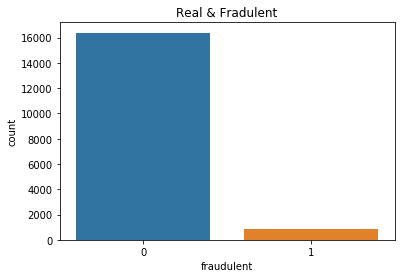

In [5]:
#Fraud and Real visualization
sn.countplot(df.fraudulent).set_title('Real & Fradulent')
df.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

In [6]:
#Add title to description column
df['description'] = df['title']+' '+df['description'] 
# Drop the title column
df.drop(['title'], axis = 1, inplace = True)

In [7]:
df2= df.copy()#make a copy

In [9]:
import spacy 
import en_core_web_lg
nlp = en_core_web_lg.load()
from spacy.lang.en import English
parser = English()
import base64
import string
import re
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from collections import Counter
punctuation = string.punctuation

# Cleaning function which is used for cleaning the text feater. 
def cleanup_text(docs, logging= False):
    texts = []
    for doc in docs:
        doc = nlp (doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip()for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuation ]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [10]:
# finding the most common words in description of fake job pots.

Fraud = [text for text in df2[df2['fraudulent']== 1] ['description']]
Fraud_clean = cleanup_text(Fraud)
Fraud_clean = ' '.join(Fraud_clean).split()
Fraud_counts = Counter(Fraud_clean)
Fraud_common_words= [word[0] for word in Fraud_counts.most_common(20)]
Fraud_common_counts = [word[1] for word in Fraud_counts.most_common(20)]

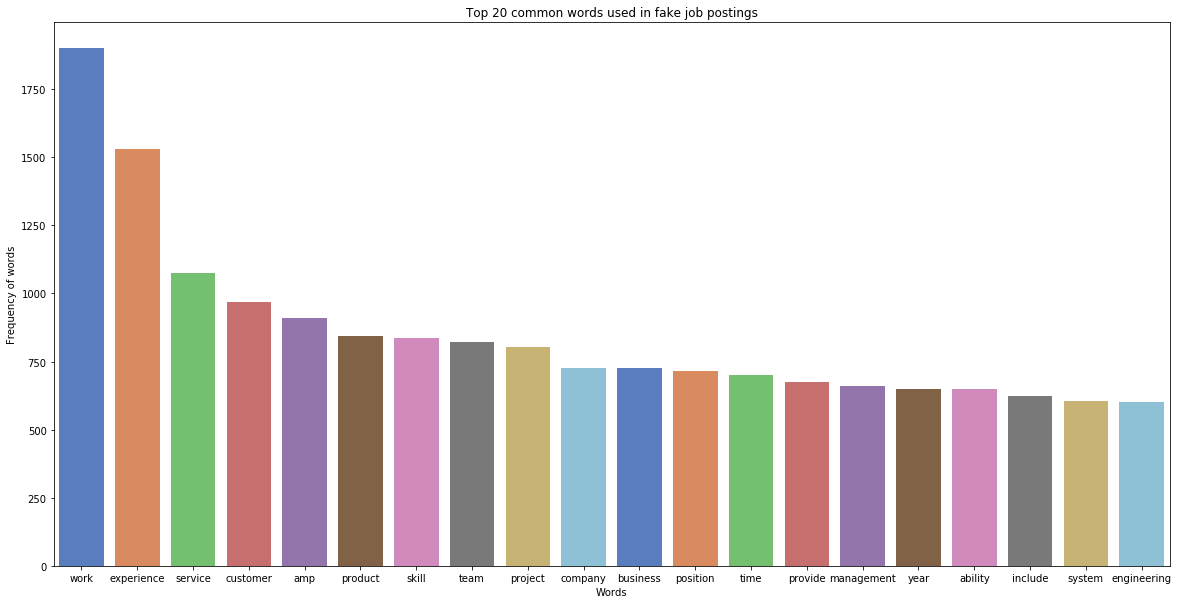

In [12]:

fig= plt.figure(figsize=(20,10))
pal=sn.color_palette("muted")
sn.barplot(x= Fraud_common_words, y=Fraud_common_counts, palette= pal)
plt.title('Top 20 common words used in fake job postings')
plt.ylabel('Frequency of words')
plt.xlabel('Words')
plt.show()

In [13]:
# finding the most common words in description of real job pots.

Real = [text for text in df2[df2['fraudulent']== 0] ['description']]
Real_clean = cleanup_text(Real)
Real_clean = ' '.join(Real_clean).split()
Real_counts = Counter(Real_clean)
Real_common_words= [word[0] for word in Real_counts.most_common(20)]
Real_common_counts = [word[1] for word in Real_counts.most_common(20)]

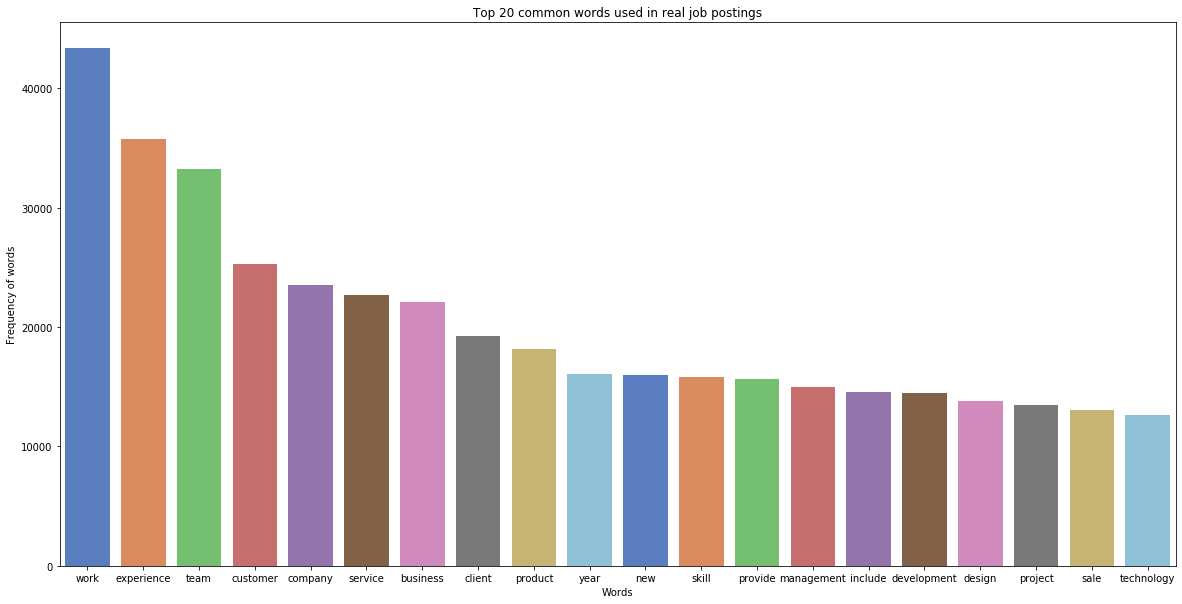

In [15]:
fig= plt.figure(figsize=(20,10))
pal=sn.color_palette("muted") 
sn.barplot(x= Real_common_words, y=Real_common_counts, palette= pal)
plt.title('Top 20 common words used in real job postings')
plt.ylabel('Frequency of words')
plt.xlabel('Words')
plt.show()

In [16]:
# drop the description column
df2.drop(['description'], axis = 1, inplace = True)


In [17]:
df3=df2.copy()# make a copy 

In [18]:
df3.to_csv('Final_CleanData.csv')

In [19]:
# Split df into train & test
y = df3.fraudulent #target
X = df3.drop(['fraudulent'], axis = 1)#features

# used train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=222)
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(13780, 9)
(13780,)
(3445, 9)
(3445,)


In [20]:
# Join our training data back together
X = pd.concat([X_train, y_train], axis=1)
# separate fake and real classes
real = X[X.fraudulent==0]
fake = X[X.fraudulent==1]

In [21]:
# downsample majority
real_downsampled = resample(real,
                                replace = False, # sample without replacement
                                n_samples = len(fake), # same as fake posts
                                random_state = 222) # reproducible results

In [22]:
# combine minority and downsampled majority
downsampled = pd.concat([real_downsampled, fake])
# number of real and fake postings
downsampled.fraudulent.value_counts()

1    667
0    667
Name: fraudulent, dtype: int64

In [23]:
y_train = downsampled.fraudulent
X_train = downsampled.drop('fraudulent', axis=1)

In [24]:
# identify the categorical and numerical columns.
numeric_features = df3.select_dtypes(include=['int64','float64']).drop(['fraudulent'], axis=1).columns
categorical_features = df3.select_dtypes(include=['object']).columns

In [25]:

# list of encoders is used. 
encoder_list = [ce.binary.BinaryEncoder, #binary encoder
                ce.ordinal.OrdinalEncoder,# ordinal_encoder
                ce.one_hot.OneHotEncoder,# one-hot encoder 
                ]


In [26]:
#LabelEncoder to transform the y labels
le = preprocessing.LabelEncoder()
label_encoder = le.fit(y)
y = label_encoder.transform(y)

In [27]:
from scipy.stats import chi2_contingency
chi2_check = []
for i in categorical_features:
    if chi2_contingency(pd.crosstab(downsampled['fraudulent'], downsampled[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [categorical_features, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
print(res)

                Column              Hypothesis
0      employment_type  Reject Null Hypothesis
1  required_experience  Reject Null Hypothesis
2   required_education  Reject Null Hypothesis
3             industry  Reject Null Hypothesis
4             function  Reject Null Hypothesis
5         country_name  Reject Null Hypothesis


In [28]:
classifiers = [
    KNeighborsClassifier(5),
    DecisionTreeClassifier(),
    RandomForestClassifier( n_estimators=500),
    LogisticRegression(),
  ]

In [32]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
for encoder in encoder_list:
    # pipeline for numeric data 
    numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
    # pipeline for categorical data 
    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('woe', encoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    for classifier in classifiers:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    
        model = pipe.fit(X_train, y_train)
   
        y_pred = model.predict(X_test)
        print(encoder)
        print(classifier)
        print("model score: %.3f" % pipe.score(X_test, y_test))
        print('F1 score: %f' % f1_score(y_test, y_pred, average='macro'))
        #print(classification_report(y_test, y_pred))
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        print(confusion_matrix(y_test,y_pred))
        print('ROC AUC: %f' %roc_auc)
        recall = recall_score(y_test, y_pred)
        print('Recall: %f' % recall)
        precision = precision_score(y_test, y_pred)
        print('Precision: %f' % precision)
        print("*******************************************\n")

    

<class 'category_encoders.binary.BinaryEncoder'>
KNeighborsClassifier()
model score: 0.818
F1 score: 0.596401
[[2684  594]
 [  34  133]]
ROC AUC: 0.807600
Recall: 0.796407
Precision: 0.182944
*******************************************

<class 'category_encoders.binary.BinaryEncoder'>
DecisionTreeClassifier()
model score: 0.798
F1 score: 0.582693
[[2613  665]
 [  30  137]]
ROC AUC: 0.808746
Recall: 0.820359
Precision: 0.170823
*******************************************

<class 'category_encoders.binary.BinaryEncoder'>
RandomForestClassifier(n_estimators=500)
model score: 0.840
F1 score: 0.630941
[[2745  533]
 [  17  150]]
ROC AUC: 0.867802
Recall: 0.898204
Precision: 0.219619
*******************************************

<class 'category_encoders.binary.BinaryEncoder'>
LogisticRegression()
model score: 0.743
F1 score: 0.539927
[[2426  852]
 [  32  135]]
ROC AUC: 0.774234
Recall: 0.808383
Precision: 0.136778
*******************************************

<class 'category_encoders.ordinal.

In [33]:
# oversample majority
fake_upsampled = resample(fake,
                                replace = True, # sample with replacement
                                n_samples = len(real), # same as fake posts
                                random_state = 222) # reproducible results

In [34]:
# combine Majority and upsampled minority
upsampled = pd.concat([fake_upsampled, real])
# number of real and fake postings
upsampled.fraudulent.value_counts()

1    13113
0    13113
Name: fraudulent, dtype: int64

In [35]:
y_train2 = upsampled.fraudulent
X_train2 = upsampled.drop('fraudulent', axis=1)

In [36]:
for encoder in encoder_list:
    # pipeline for numeric data 
    numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
    # pipeline for categorical data 
    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('woe', encoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    for classifier in classifiers:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    
        model = pipe.fit(X_train2, y_train2)
   
        y_pred2 = model.predict(X_test)
        print(encoder)
        print(classifier)
        print("model score: %.3f" % pipe.score(X_test, y_test))
        
        print('F1 score: %f' % f1_score(y_test, y_pred2, average='macro'))
        print(classification_report(y_test, y_pred2))
        fpr, tpr, threshold = roc_curve(y_test, y_pred2)
        roc_auc = auc(fpr, tpr)
        #print(classification_report(y_test, y_pred2))
        fpr, tpr, threshold = roc_curve(y_test, y_pred2)
        roc_auc = auc(fpr, tpr)
        print(confusion_matrix(y_test,y_pred2))
        print('ROC AUC: %f' %roc_auc)
        recall = recall_score(y_test, y_pred2)
        print('Recall: %f' % recall)
        precision = precision_score(y_test, y_pred2)
        print('Precision: %f' % precision)
        print("*********************************************\n")
        

<class 'category_encoders.binary.BinaryEncoder'>
KNeighborsClassifier()
model score: 0.869
F1 score: 0.660971
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3278
           1       0.25      0.88      0.40       167

    accuracy                           0.87      3445
   macro avg       0.62      0.87      0.66      3445
weighted avg       0.96      0.87      0.90      3445

[[2848  430]
 [  20  147]]
ROC AUC: 0.874531
Recall: 0.880240
Precision: 0.254766
*********************************************

<class 'category_encoders.binary.BinaryEncoder'>
DecisionTreeClassifier()
model score: 0.949
F1 score: 0.774869
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3278
           1       0.48      0.72      0.58       167

    accuracy                           0.95      3445
   macro avg       0.73      0.84      0.77      3445
weighted avg       0.96      0.95      0.95      3

C:\Users\soley\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<class 'category_encoders.binary.BinaryEncoder'>
LogisticRegression()
model score: 0.793
F1 score: 0.573357
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3278
           1       0.16      0.78      0.27       167

    accuracy                           0.79      3445
   macro avg       0.57      0.79      0.57      3445
weighted avg       0.95      0.79      0.85      3445

[[2602  676]
 [  37  130]]
ROC AUC: 0.786110
Recall: 0.778443
Precision: 0.161290
*********************************************

<class 'category_encoders.ordinal.OrdinalEncoder'>
KNeighborsClassifier()
model score: 0.931
F1 score: 0.734126
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3278
           1       0.39      0.72      0.51       167

    accuracy                           0.93      3445
   macro avg       0.69      0.83      0.73      3445
weighted avg       0.96      0.93      0.94      344

C:\Users\soley\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<class 'category_encoders.one_hot.OneHotEncoder'>
LogisticRegression()
model score: 0.830
F1 score: 0.613024
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      3278
           1       0.20      0.84      0.32       167

    accuracy                           0.83      3445
   macro avg       0.60      0.83      0.61      3445
weighted avg       0.95      0.83      0.87      3445

[[2719  559]
 [  27  140]]
ROC AUC: 0.833896
Recall: 0.838323
Precision: 0.200286
*********************************************

